## eBay Baseball Card Data Scraper

In [1]:
import requests
import urllib
import numpy as np
import pandas as pd
from scipy import stats
from selenium import webdriver
from bs4 import BeautifulSoup as bs

In [2]:
def get_grade(title):

    index = ''

    grading_companies = ['PSA', 'psa', 'BGS', 'bgs', 'HGA', 'hga', 'SGC', 'sgc']
    for company in grading_companies:
        index = title.find(company)
        if (index != -1):
            return title[index:index + 7]
    
    return None

def get_sale_type(item):
    sale = getattr(item.find('span', {'class': 's-item__purchase-options-with-icon'}), 'text', None)
    if sale is not None:
        return sale
    else:
        return 'Auction'

def get_sold_date(item):
    if getattr(item.find('div', {'class': 's-item__title--tagblock'}), 'text', None) is not None:
        return item.find('div', {'class': 's-item__title--tagblock'}).find('span', {'class': 'POSITIVE'}).text
    else:
        return None
    

In [3]:
from cgitb import text
from webbrowser import get


class EbayScraper:
    def __init__(self, keywords, pages):
        self.keywords = keywords
        self.pages = pages

    def add_plus(self):
        return self.keywords.replace(' ', '+')
    
    def href_builder(self):
        links = []
        keywords = self.add_plus()

        for i in range(self.pages):
            links.append('https://www.ebay.com/sch/i.html?_nkw=' + keywords + '&_sop=13&LH_Sold=1&LH_Complete=1&_pgn=' + str(i) + '&rt=nc')
        return links
        
    def get_data(self):

        soups = []
        links = self.href_builder()

        for link in links:
            page = requests.get(link)
            soup = bs(page.text, 'html.parser')
            soups.append(soup)

        return soups
        
    def parse(self):

        soups = self.get_data()
        results = []
        product_list = []

        for soup in soups:
            results.extend(soup.find_all('div', {'class': 's-item__info clearfix'}))

        for item in results:
            products = {
                'title': getattr(item.find('span', {'role': 'heading'}), 'text', None),
                'grade': get_grade(getattr(item.find('span', {'role': 'heading'}), 'text', None)),
                'soldprice': item.find('span', {'class': 's-item__price'}).text.replace("$", '').replace(',', '').strip(),
                'solddate':get_sold_date(item),
                'saletype': get_sale_type(item),
                'bids': getattr(item.find('span', {'class': 's-item__bids s-item__bidCount'}), 'text', None),
                'link': item.find('a', {'class': 's-item__link'})['href'],
                'image': getattr(item.find('img', {'class': 's-item__image-img'}), 'src', None),
            }
            product_list.append(products)
        return product_list

    def output(self):
        products = self.parse()
        df = pd.DataFrame(products)
        df.to_csv('ebay_output.csv', index=False)
        return df
    

In [4]:
zion = EbayScraper('2019 panini prizm zion williamson 248 psa 9', 8)
zion_out = zion.output()

In [5]:
zion_out

,title,grade,soldprice,solddate,saletype,bids,link,image
0,Shop on eBay,None,20.00,None,Auction,None,https://ebay.com/itm/123456?hash=item28caef0a3...,None
1,Zion Williamson 2019 Panini Prizm PSA 9 Rookie...,PSA 9 R,89.99,"Sold Sep 5, 2022",Best offer accepted,None,https://www.ebay.com/itm/295199607634?hash=ite...,None
2,2019-20 Zion Williamson Panini Prizm Ruby Wave...,PSA 9 M,239.49,"Sold Sep 4, 2022",Auction,21 bids,https://www.ebay.com/itm/295195427642?hash=ite...,None
3,Zion Williamson 2019 Panini Prizm #248 PSA 9,PSA 9,63.00,"Sold Sep 4, 2022",Auction,13 bids,https://www.ebay.com/itm/403856285037?hash=ite...,None
4,Zion Williamson 2019 Panini Prizm PSA 9 Rookie...,PSA 9 R,79.99,"Sold Sep 4, 2022",Buy It Now,None,https://www.ebay.com/itm/204081445934?hash=ite...,None
...,...,...,...,...,...,...,...,...
300,Zion Williamson 2019 20 Panini Prizm #248 peli...,PSA 9,142.50,"Sold Jul 18, 2022",Auction,35 bids,https://www.ebay.com/itm/363904845208?hash=ite...,None
301,Zion Williamson 2019 Panini Prizm Pink Ice Pri...,PSA 9,199.00,"Sold Jul 18, 2022",Auction,2 bids,https://www.ebay.com/itm/304563079517?hash=ite...,None
302,2019 Panini Prizm #248 Zion Williamson Pelican...,PSA 9 M,76.01,"Sold Jul 18, 2022",Auction,6 bids,https://www.ebay.com/itm/304560603692?hash=ite...,None
303,2019 Panini Prizm Green #248 Zion Williamson R...,PSA 9,155.50,"Sold Jul 17, 2022",Auction,23 bids,https://www.ebay.com/itm/403767215671?hash=ite...,None


In [6]:
zion_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      305 non-null    object
 1   grade      292 non-null    object
 2   soldprice  305 non-null    object
 3   solddate   300 non-null    object
 4   saletype   305 non-null    object
 5   bids       194 non-null    object
 6   link       305 non-null    object
 7   image      0 non-null      object
dtypes: object(8)
memory usage: 19.2+ KB


In [6]:
lewis = EbayScraper('2020 lewis hamilton #1 psa 10', 7)
lewis_out = lewis.output()

In [7]:
lewis_out

,title,grade,soldprice,solddate,saletype,bids,link,image
0,Shop on eBay,None,20.00,None,Auction,None,https://ebay.com/itm/123456?hash=item28caef0a3...,None
1,New ListingLEWIS HAMILTON 2020 TOPPS CHROME F1...,PSA 9 M,150.00,None,or Best Offer,None,https://www.ebay.com/itm/175379953188?hash=ite...,None
2,2020 Topps Now Formula 1 Lewis Hamilton Racing...,PSA 10,123.75,None,or Best Offer,None,https://www.ebay.com/itm/203791558643?hash=ite...,None
3,2020 Lewis Hamilton Topps Chrome Sapphire PSA ...,PSA 10,125.00,None,or Best Offer,None,https://www.ebay.com/itm/185530077893?hash=ite...,None
4,66012915 LEWIS HAMILTON 2020 Topps Chrome F1 1...,PSA 10,189.50,None,Auction,12 bids ·,https://www.ebay.com/itm/155105648406?hash=ite...,None
...,...,...,...,...,...,...,...,...
491,New Listing2020 Topps Chrome F1 Refractor Lewi...,PSA 10,2.25,None,Auction,2 bids ·,https://www.ebay.com/itm/284928333654?hash=ite...,None
492,2020 Topps Chrome Formula 1 LEWIS HAMILTON Car...,None,15.50,None,Auction,3 bids ·,https://www.ebay.com/itm/144671371319?hash=ite...,None
493,2020 Topps Chrome Formula 1 Sapphire Lewis Ham...,PSA 10,10.50,None,Auction,3 bids ·,https://www.ebay.com/itm/165616624196?hash=ite...,None
494,Lewis Hamilton 2020 Topps Chrome Sapphire F1 S...,SGC 10,119.99,None,or Best Offer,None,https://www.ebay.com/itm/144671786149?hash=ite...,None


In [8]:
zion_out

,title,grade,soldprice,solddate,saletype,bids,link,image
0,Shop on eBay,None,20.0,None,Auction,None,https://ebay.com/itm/123456?hash=item28caef0a3...,None
1,2019 panini prizm #248 zion williamson rc; sil...,PSA 9 💥,400.0,None,or Best Offer,None,https://www.ebay.com/itm/325298857991?hash=ite...,None
2,2019-20 Panini Prizm #248 Zion Williamson Peli...,PSA 9 M,65.0,None,Auction,31 bids,https://www.ebay.com/itm/374200454423?hash=ite...,None
3,2019-20 Panini Prizm #248 Zion Williamson Peli...,PSA 9 M,66.0,None,Auction,17 bids,https://www.ebay.com/itm/363931158532?hash=ite...,None
4,2019-20 Panini Prizm #248 Zion Williamson Peli...,PSA 9 M,67.0,None,Auction,23 bids,https://www.ebay.com/itm/125446887303?hash=ite...,None
...,...,...,...,...,...,...,...,...
300,"2019 Panini Prizm, #248, Zion Williamson ROOKI...",PSA 9 M,62.0,None,Auction,14 bids,https://www.ebay.com/itm/144605186085?hash=ite...,None
301,2019-20 Panini Prizm Zion Williamson Green Roo...,PSA 9,110.0,None,Auction,9 bids,https://www.ebay.com/itm/304528531632?hash=ite...,None
302,2019 Panini Prizm Green #248 Zion Williamson R...,PSA 9,115.0,None,Auction,25 bids,https://www.ebay.com/itm/334475651963?hash=ite...,None
303,MARVIN BAGLEY III 2018-19 PANINI PRIZM GREEN #...,PSA 9 M,20.0,None,Buy It Now,None,https://www.ebay.com/itm/115350348023?hash=ite...,None


In [18]:
carlos = EbayScraper('2020 carlos sainz dynastly auto', 1)
carlos_out = carlos.output()

<AxesSubplot:>

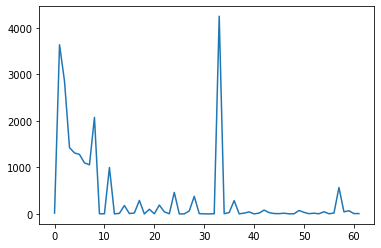

In [21]:
carlos_out['soldprice'].plot()

In [17]:
carlos_out['grade'].value_counts()

PSA 10     6
PSA 10     6
PSA 9 #    4
PSA 9 1    2
PSA8/10    2
PSA 9 🔥    2
PSA 9 T    2
PSA 9      2
PSA 9 M    2
SGC 10     2
Name: grade, dtype: int64

In [ ]:
strict = carlos_out[carlos_out['title']]

In [26]:
herro = EbayScraper('tyler herro autograph', 9)
herro_out = herro.output()

In [27]:
herro_out

,title,grade,soldprice,solddate,saletype,bids,link,image
0,Shop on eBay,None,20.00,None,Auction,None,https://ebay.com/itm/123456?hash=item28caef0a3...,None
1,RJ Barrett 2019-20 Panini Immaculate Rookie Pa...,BGS 8.5,500.00,None,Best offer accepted,None,https://www.ebay.com/itm/115481862691?hash=ite...,None
2,2019 PANINI PRIZM TYLER HERRO RC BALL BEHIND B...,PSA 10,13.00,None,Auction,14 bids,https://www.ebay.com/itm/234649948690?hash=ite...,None
3,2019 PANINI PRIZM TYLER HERRO RC BALL BEHIND B...,PSA 8 T,4.25,None,Auction,6 bids,https://www.ebay.com/itm/234649946773?hash=ite...,None
4,Tyler Herro Instant Access 1/1 HGA Graded 8.5,HGA Gra,900.00,None,Best offer accepted,None,https://www.ebay.com/itm/125446603727?hash=ite...,None
...,...,...,...,...,...,...,...,...
300,2019-20 Panini Revolution Tyler Herro RC Rooki...,PSA 9 /,107.50,None,Auction,20 bids,https://www.ebay.com/itm/185462657914?hash=ite...,None
301,"Lot of 4 Tyler Herro Cards Auto, Prizms",None,129.99,None,or Best Offer,None,https://www.ebay.com/itm/403536015187?hash=ite...,None
302,Tyler Herro 2019-20 Panini Prizm Draft Picks S...,None,61.00,None,Auction,18 bids,https://www.ebay.com/itm/325224458208?hash=ite...,None
303,Tyler Herro 2019-20 Panini Contenders Rookie T...,None,182.50,None,Auction,18 bids,https://www.ebay.com/itm/265734482784?hash=ite...,None
